# RecSys - iMult-VAE on million songs dataset (MSD)

Teammates:

*   Hila Delouya I.D. 302444534 
*   Yarin Ozery I.D. 206829145

#### Imports

In [ ]:
import os
import copy
import shutil
import sys
import math
import sqlite3
import numbers
import scipy
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import bottleneck as bn
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn import preprocessing

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from google.colab import drive
from tensorflow.python import ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.framework import constant_op
from tensorflow.python.platform import tf_logging as logging
sn.set()

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import tensorboard
%load_ext tensorboard

#### Functions

In [ ]:
def get_count(tp, id):
    """
    Returns a groupby table per col name with events count
    Args:
      tp: data frame
      id: id col name to groupby
    Returns:
      A groupby table per col name with counted events.
    """
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

def filter_triplets(tp, min_uc=20, min_sc=200):
    """ 
    Function that filters songs and users based on thresholds
    Args:
      tp: data frame
      min_uc: minimum number of songs a user interacted with
      min_sc: minimum number of users that interacted with a song
    Returns:
      A fitered data frame based on thresholds
    """
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, item_id)
        tp = tp[tp[item_id].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, user_id)
        tp = tp[tp[user_id].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, user_id), get_count(tp, item_id) 
    return tp, usercount, itemcount

def split_train_test_proportion(data, min_items=5, test_prop=0.2):
    """ Splits the data into train-test sets.
    Args:
      data:      data frame to be split
      min_items: minimum number of items interactions required for a user
                 in order to qualify for splitting his data (if there are
                 fewer interactions, all his interactions are added to training
                 set). 
      test_prop: proportion of user's interactions to be moved to test set,
                 rest of the data will be in the training set. 
    Returns:
      train-test splitted datasets of the input dataset 
    """
    data_grouped_by_user = data.groupby(user_id)
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= min_items:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)

    return data_tr, data_te

def numerize(tp, user_id, item_id):
    """
    This function indexes user ids and songs ids
    Args:
      tp: Dataframe consisting of pairs of user_id, item_id, representing 
          user-item interaction in the dataset      
      user_id: name of the user id column in tp
      item_id: name of the item id column in tp
    Returns:
      An indexed version of the input interaction dataframe
    """
    data = copy.deepcopy(tp)
    data[user_id] = list(map(lambda x: profile2id[x], data[user_id]))
    data[item_id] =  list(map(lambda x: show2id[x], data[item_id]))
    return data

def load_train_data(train_csv_file, user_id, item_id, n_items):
    """
    This function loads the trainig data into a user-item interaction
    sparse matrix between all users and items.
    Args:
      train_csv_file: csv file consisting of user-item interactions     
      user_id: name of the user id column in tp
      item_id: name of the item id column in tp
      n_items: number of items in the entire dataset
    Returns:
      a sparse one-hot-encoded matrix, where for each row u and each column s
      the cell data[u,s] = 1 if user u interacted with song s, otherwise,
      data[u,s] = 0 
    """
    tp = pd.read_csv(train_csv_file)
    n_users = tp[user_id].max() + 1

    rows, cols = tp[user_id], tp[item_id]
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    
    return data

def load_tr_te_data(validation_tr_csv_file, validation_te_csv_file, user_id, item_id, n_items):
    """
    This function loads the test dataset into a user-item interaction
    sparse matrix between all users and items in the test set.
    It differs from the previous function from the fact that the test set
    itself was split into "training-test" sets where training set is used to
    learn the necessary user-level representations for
    the model and then compute metrics by looking at how well the
    model ranks the rest of the interactions.
    Args:
      validation_tr_csv_file: csv file consisting of test sets user-item interactions,
                              which is used for the "training part"
      validation_te_csv_file: csv file consisting of test sets user-item interactions,
                              which is used for the evaluation part.     
      user_id: name of the user id column in tp
      item_id: name of the item id column in tp
      n_items: number of items in the entire dataset
    Returns:
      Two sparse one-hot-encoded matrices, where for each row u and each column s
      the cell data[u,s] = 1 if user u interacted with song s, otherwise,
      data[u,s] = 0, for each of the csv files
    """
    tp_tr = pd.read_csv(validation_tr_csv_file)
    tp_te = pd.read_csv(validation_te_csv_file)

    start_idx = min(tp_tr[user_id].min(), tp_te[user_id].min())
    end_idx = max(tp_tr[user_id].max(), tp_te[user_id].max())

    rows_tr, cols_tr = tp_tr[user_id] - start_idx, tp_tr[item_id]
    rows_te, cols_te = tp_te[user_id] - start_idx, tp_te[item_id]

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

    return data_tr, data_te

def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    """
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    Args:
      X_pred: model's rank prediction for the "training" part
      heldout_batch: the appropriate "test" batch for the given prediction
      k:  Number of shown recommendations
    Returns:
      NDCG@k value for given predictions

    """
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    """
    Calculates Recall@K value for given prediction
    Args:
      X_pred: model's rank prediction for the "training" part
      heldout_batch: the appropriate "test" batch for the given prediction
      k:  Number of shown recommendations
    Returns:
      Recall@k value for given predictions
    """
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

def categorial_feature_encodeing(df, feature_name):
    """
    Encoding categorical features into numerical values (label encoding)
    Args:
      df: dataframe which contains feature to be encoded
      feature_name:  feature name to be encoded
    Returns:
      the input dataframe, where feature feature_name is encoded
    """

  categories = list(set(df[feature_name]))

  # create a dictionary of values and corresponding number {value, number}
  dict_values = {value: count for value, count in zip(categories, range(1,len(categories)+1))}

  # Encoding:
  df[feature_name] = df[feature_name].map(lambda x: dict_values.get(x))

  return df


def flatten(nested_list):
    """
    Flattens nested lists, recursively
    """
    for i in nested_list:
        if isinstance(i, (list, tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

def flatten_list(nested_list):
    return list(flatten(nested_list))

## Data preprocessing

#### Data Load

In [ ]:
# Config:
PROJ_DIR = "Enter your project path"
user_id = 'userId'
item_id = 'songId'
rating = 'play_count'

In [ ]:
# Create folders:

output_dir = os.path.join(PROJ_DIR, 'pro_sg')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
# Read Data:
names = [user_id, item_id, rating]
raw_data = pd.read_csv(os.path.join(PROJ_DIR, 'data/train_triplets.txt'), sep='\t', names=names, low_memory=False)

In [ ]:
# Load DB:
conn = sqlite3.connect(os.path.join(PROJ_DIR, 'data/track_metadata.db'))
songs_info_df = pd.read_sql_query("SELECT * FROM songs", conn)

In [ ]:
raw_data.head(4)

,userId,songId,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1


In [ ]:
songs_info_df.head(4)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0


#### Exploratory Data Analysis

In [ ]:
usercount = get_count(raw_data, user_id)
mean = np.mean(usercount)
std = np.std(usercount)
no_outliers_usercount = usercount[usercount<=mean+(2*std)]

Text(0.5, 0, 'Number of songs each user listens to')

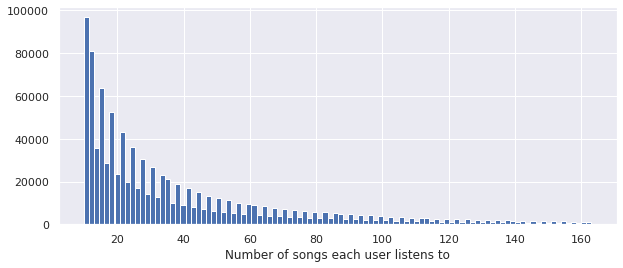

In [ ]:
plt.figure(figsize=(10, 4))
no_outliers_usercount.hist(bins=100)
plt.xlabel('Number of songs each user listens to')

In [ ]:
songcount = get_count(raw_data, item_id)
mean = np.mean(songcount)
std = np.std(songcount)
no_outliers_songcount = songcount[songcount<=mean+(2*std)]

Text(0.5, 0, 'Number of users by which each song is listened to')

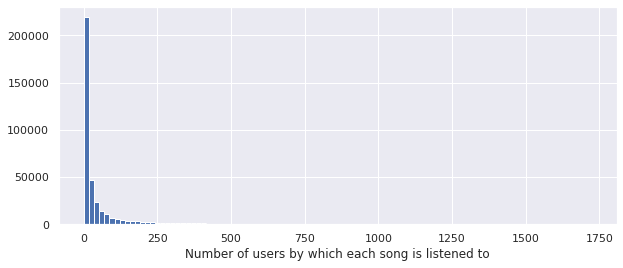

In [ ]:
plt.figure(figsize=(10, 4))
no_outliers_songcount.hist(bins=100)
plt.xlabel('Number of users by which each song is listened to')

#### Songs side information - Data Preprocessing

In [ ]:
songs_info_df = songs_info_df.rename(columns={'song_id':item_id})

In [ ]:
side_info_features = []
categorial_features = ['title','release','artist_id','shs_perf','shs_work']
numeric_features = ['duration','artist_familiarity','artist_hotttnesss','year']

side_info_features.append([item_id])
side_info_features.append(categorial_features)
side_info_features.append(numeric_features)
side_info_features = flatten_list(nested_list=side_info_features)

In [ ]:
# Subset to relevent features:
songs_info_df = songs_info_df[side_info_features]

In [ ]:
# Drop duplicates:
songs_info_df = songs_info_df.drop_duplicates()
songs_info_df_gb = songs_info_df.groupby(item_id).count().reset_index()
duplicates_song_info_list = list(songs_info_df_gb[songs_info_df_gb['title']>1][item_id])
songs_info_df[songs_info_df[item_id].isin(duplicates_song_info_list)].sort_values(item_id).head(4)

,songId,title,release,artist_id,shs_perf,shs_work,duration,artist_familiarity,artist_hotttnesss,year
304966,SOAAEFC12AB01852F1,De Tongbreker (Tineke Schouten & Linda de Mol),16 Liedjes Uit De Tineke Schouten Shows,AR0EEUF1187B9AABED,-1,0,219.37587,0.064534,0.000000,0
963681,SOAAEFC12AB01852F1,De Tongbreker,Alle 40 Goed - Hollandse Duetten,AR0EEUF1187B9AABED,-1,0,219.61098,0.064534,0.000000,0
572832,SOACGAQ12A58A79805,Fire And The Thud,Humbug,ARM0P6Z1187FB4D466,-1,0,239.51628,0.816597,0.564911,2009
141269,SOACGAQ12A58A79805,Fire And The Thud,Humbug,ARM0P6Z1187FB4D466,-1,0,237.40036,0.816597,0.553661,2009


In [ ]:
songs_info_df = songs_info_df.drop_duplicates(subset=item_id)
songs_info_df = songs_info_df.reset_index(drop=True)
songs_info_df.shape[0]

999056

In [ ]:
# Handle nan values:
for feature_name in ['artist_familiarity','artist_hotttnesss']:
  avg = np.mean(songs_info_df[songs_info_df[feature_name]!=-1][feature_name])
  songs_info_df[feature_name] = songs_info_df[feature_name].apply(lambda x: avg if x==-1 else x)

for feature_name in ['year']:
  avg = np.mean(songs_info_df[songs_info_df[feature_name]!=0][feature_name])
  songs_info_df[feature_name] = songs_info_df[feature_name].apply(lambda x: avg if x==0 else x)

In [ ]:
# Convert dtypes:
for feature_name in categorial_features:
  songs_info_df[feature_name] = songs_info_df[feature_name].astype(str)

In [ ]:
# Categorial numeric hashing:
for feature_name in categorial_features:
  songs_info_df = categorial_feature_encodeing(df=songs_info_df, feature_name=feature_name)

In [ ]:
# Feature scaling:
for feature_name in numeric_features:
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
  songs_info_df[feature_name] = min_max_scaler.fit_transform(songs_info_df[[feature_name]])

In [ ]:
songs_info_df.head(4)

,songId,title,release,artist_id,shs_perf,shs_work,duration,artist_familiarity,artist_hotttnesss,year
0,SOQMMHC12AB0180CB8,405780,127136,43022,14909,2041,0.082957,0.649822,0.364001,0.910112
1,SOVFVAK12A8C1350D9,35,9083,42162,14909,2041,0.051486,0.439604,0.329784,0.820225
2,SOGTUKN12AB017F4F1,574703,49912,27522,14909,2041,0.045692,0.643681,0.404160,0.943820
3,SOBNYVR12A8C13558C,290030,2609,24852,14909,2041,0.047698,0.448501,0.343971,0.910112


In [ ]:
songs_info_df = songs_info_df[['songId','duration','artist_familiarity','artist_hotttnesss','year']]

In [ ]:
# Merge with side info:
original_shape = raw_data.shape[0]
raw_data = raw_data.merge(songs_info_df, on=item_id, how='left')

In [ ]:
raw_data = raw_data.dropna()
new_shape = raw_data.shape[0]
print("DF new shape is: {n}, {s} songs have been removed.".format(n=str(new_shape),s=str(original_shape-new_shape)))

DF new shape is: 48373586, 0 songs have been removed.


In [ ]:
# Feature scaling:
for feature_name in ['play_count']:
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
  raw_data[feature_name] = min_max_scaler.fit_transform(raw_data[[feature_name]])

### Data splitting procedure

In [ ]:
# Filter data:
min_uc=6
min_sc=50
raw_data, user_activity, item_popularity = filter_triplets(raw_data, min_uc=min_uc, min_sc=min_sc)

In [ ]:
# Data Stats:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d listening events from %d users and %d songs (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 39415474 listening events from 629112 users and 91522 songs (sparsity: 0.068%)


In [ ]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [ ]:
# create train/validation/test users:
n_users = unique_uid.size
n_heldout_users = 50000

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [ ]:
train_plays = raw_data.loc[raw_data[user_id].isin(tr_users)]

In [ ]:
unique_sid = pd.unique(train_plays[item_id])

In [ ]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [ ]:
song_df = copy.deepcopy(raw_data)

In [ ]:
cols = list(song_df.columns)
cols.remove(item_id)
cols.remove(user_id)
song_df['song_numeric_id'] = song_df[item_id].apply(lambda x: show2id[x])
song_df = song_df.drop_duplicates(subset=['song_numeric_id'])
cols.append('song_numeric_id')
song_df = song_df[cols]
song_df = song_df.sort_values(by='song_numeric_id').reset_index(drop=True)
song_df = song_df.set_index('song_numeric_id')
assert song_df.shape[0]==item_popularity.shape[0]

In [ ]:
song_df.to_csv(os.path.join(output_dir, 'song_df.csv'), index=False)

In [ ]:
with open(os.path.join(output_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [ ]:
vad_plays = raw_data.loc[raw_data[user_id].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays[item_id].isin(unique_sid)]

In [ ]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays, min_items=5)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled
12000 users sampled
13000 users sampled
14000 users sampled
15000 users sampled
16000 users sampled
17000 users sampled
18000 users sampled
19000 users sampled
20000 users sampled
21000 users sampled
22000 users sampled
23000 users sampled
24000 users sampled
25000 users sampled
26000 users sampled
27000 users sampled
28000 users sampled
29000 users sampled
30000 users sampled
31000 users sampled
32000 users sampled
33000 users sampled
34000 users sampled
35000 users sampled
36000 users sampled
37000 users sampled
38000 users sampled
39000 users sampled
40000 users sampled
41000 users sampled
42000 users sampled
43000 users sampled
44000 users sampled
45000 users sampled
46000 users sampled
47000 users sampled
48000 users sampled
49000 users sampled


In [ ]:
test_plays = raw_data.loc[raw_data[user_id].isin(te_users)]
test_plays = test_plays.loc[test_plays[item_id].isin(unique_sid)]

In [ ]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays, min_items=5)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled
12000 users sampled
13000 users sampled
14000 users sampled
15000 users sampled
16000 users sampled
17000 users sampled
18000 users sampled
19000 users sampled
20000 users sampled
21000 users sampled
22000 users sampled
23000 users sampled
24000 users sampled
25000 users sampled
26000 users sampled
27000 users sampled
28000 users sampled
29000 users sampled
30000 users sampled
31000 users sampled
32000 users sampled
33000 users sampled
34000 users sampled
35000 users sampled
36000 users sampled
37000 users sampled
38000 users sampled
39000 users sampled
40000 users sampled
41000 users sampled
42000 users sampled
43000 users sampled
44000 users sampled
45000 users sampled
46000 users sampled
47000 users sampled
48000 users sampled
49000 users sampled


### Save the data into (user_index, item_index) format

In [ ]:
train_data = numerize(train_plays, user_id, item_id)
train_data.to_csv(os.path.join(output_dir, 'train.csv'), index=False)

In [ ]:
vad_data_tr = numerize(vad_plays_tr, user_id, item_id)
vad_data_tr.to_csv(os.path.join(output_dir, 'validation_tr.csv'), index=False)

In [ ]:
vad_data_te = numerize(vad_plays_te, user_id, item_id)
vad_data_te.to_csv(os.path.join(output_dir, 'validation_te.csv'), index=False)

In [ ]:
test_data_tr = numerize(test_plays_tr, user_id, item_id)
test_data_tr.to_csv(os.path.join(output_dir, 'test_tr.csv'), index=False)

In [ ]:
test_data_te = numerize(test_plays_te, user_id, item_id)
test_data_te.to_csv(os.path.join(output_dir, 'test_te.csv'), index=False)

## Model definition and training

### Model definition

__Notations__: We use $u \in \{1,\dots,U\}$ to index users and $i \in \{1,\dots,I\}$ to index items. In this work, we consider learning with implicit feedback. The user-by-item interaction matrix is the click matrix $\mathbf{X} \in \mathbb{N}^{U\times I}$. The lower case $\mathbf{x}_u =[X_{u1},\dots,X_{uI}]^\top \in \mathbb{N}^I$ is a bag-of-words vector with the number of clicks for each item from user u. We binarize the click matrix. It is straightforward to extend it to general count data.

__Generative process__: For each user $u$, the model starts by sampling a $K$-dimensional latent representation $\mathbf{z}_u$ from a standard Gaussian prior. The latent representation $\mathbf{z}_u$ is transformed via a non-linear function $f_\theta (\cdot) \in \mathbb{R}^I$ to produce a probability distribution over $I$ items $\pi (\mathbf{z}_u)$ from which the click history $\mathbf{x}_u$ is assumed to have been drawn:

$$
\mathbf{z}_u \sim \mathcal{N}(0, \mathbf{I}_K),  \pi(\mathbf{z}_u) \propto \exp\{f_\theta (\mathbf{z}_u\},\\
\mathbf{x}_u \sim \mathrm{Mult}(N_u, \pi(\mathbf{z}_u))
$$

The objective for Multi-DAE for a single user $u$ is:
$$
\mathcal{L}_u(\theta, \phi) = \log p_\theta(\mathbf{x}_u | g_\phi(\mathbf{x}_u))
$$
where $g_\phi(\cdot)$ is the non-linear "encoder" function.

In [ ]:
def l2_regularizer(scale, scope=None):
  """Returns a function that can be used to apply L2 regularization to weights.
  Small values of L2 can help prevent overfitting the training data.
  Args:
    scale: A scalar multiplier `Tensor`. 0.0 disables the regularizer.
    scope: An optional scope name.
  Returns:
    A function with signature `l2(weights)` that applies L2 regularization.
  Raises:
    ValueError: If scale is negative or if scale is not a float.
  """
  if isinstance(scale, numbers.Integral):
    raise ValueError('scale cannot be an integer: %s' % (scale,))
  if isinstance(scale, numbers.Real):
    if scale < 0.:
      raise ValueError('Setting a scale less than 0 on a regularizer: %g.' %
                       scale)
    if scale == 0.:
      logging.info('Scale of 0 disables regularizer.')
      return lambda _: None



def apply_regularization(regularizer, weights_list=None):
  """Returns the summed penalty by applying `regularizer` to the `weights_list`.
  Adding a regularization penalty over the layer weights and embedding weights
  can help prevent overfitting the training data. Regularization over layer
  biases is less common/useful, but assuming proper data preprocessing/mean
  subtraction, it usually shouldn't hurt much either.
  Args:
    regularizer: A function that takes a single `Tensor` argument and returns
      a scalar `Tensor` output.
    weights_list: List of weights `Tensors` or `Variables` to apply
      `regularizer` over. Defaults to the `GraphKeys.WEIGHTS` collection if
      `None`.
  Returns:
    A scalar representing the overall regularization penalty.
  Raises:
    ValueError: If `regularizer` does not return a scalar output, or if we find
        no weights.
  """
  if not weights_list:
    weights_list = ops.get_collection(ops.GraphKeys.WEIGHTS)
  if not weights_list:
    raise ValueError('No weights to regularize.')
  with ops.name_scope('get_regularization_penalty',
                      values=weights_list) as scope:
    penalties = [regularizer(w) for w in weights_list]
    penalties = [
        p if p is not None else constant_op.constant(0.0) for p in penalties
    ]
    for p in penalties:
      if p.get_shape().ndims != 0:
        raise ValueError('regularizer must return a scalar Tensor instead of a '
                         'Tensor with rank %d.' % p.get_shape().ndims)

    summed_penalty = math_ops.add_n(penalties, name=scope)
    ops.add_to_collection(ops.GraphKeys.REGULARIZATION_LOSSES, summed_penalty)
    return summed_penalty


def variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False,
                                 seed=None, dtype=tf.dtypes.float32):
  """Returns an initializer that generates tensors without scaling variance.
  When initializing a deep network, it is in principle advantageous to keep
  the scale of the input variance constant, so it does not explode or diminish
  by reaching the final layer. This initializer use the following formula:
  ```python
    if mode='FAN_IN': # Count only number of input connections.
      n = fan_in
    elif mode='FAN_OUT': # Count only number of output connections.
      n = fan_out
    elif mode='FAN_AVG': # Average number of inputs and output connections.
      n = (fan_in + fan_out)/2.0
      truncated_normal(shape, 0.0, stddev=sqrt(factor / n))
  ```
  * To get [Delving Deep into Rectifiers](
     http://arxiv.org/pdf/1502.01852v1.pdf) (also know as the "MSRA 
     initialization"), use (Default):<br/>
    `factor=2.0 mode='FAN_IN' uniform=False`
  * To get [Convolutional Architecture for Fast Feature Embedding](
     http://arxiv.org/abs/1408.5093), use:<br/>
    `factor=1.0 mode='FAN_IN' uniform=True`
  * To get [Understanding the difficulty of training deep feedforward neural
    networks](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf),
    use:<br/>
    `factor=1.0 mode='FAN_AVG' uniform=True.`
  * To get `xavier_initializer` use either:<br/>
    `factor=1.0 mode='FAN_AVG' uniform=True`, or<br/>
    `factor=1.0 mode='FAN_AVG' uniform=False`.
  Args:
    factor: Float.  A multiplicative factor.
    mode: String.  'FAN_IN', 'FAN_OUT', 'FAN_AVG'.
    uniform: Whether to use uniform or normal distributed random initialization.
    seed: A Python integer. Used to create random seeds. See
          `tf.compat.v1.set_random_seed` for behavior.
    dtype: The data type. Only floating point types are supported.
  Returns:
    An initializer that generates tensors with unit variance.
  Raises:
    ValueError: if `dtype` is not a floating point type.
    TypeError: if `mode` is not in ['FAN_IN', 'FAN_OUT', 'FAN_AVG'].
  """
  if not dtype.is_floating:
    raise TypeError('Cannot create initializer for non-floating point type.')
  if mode not in ['FAN_IN', 'FAN_OUT', 'FAN_AVG']:
    raise TypeError('Unknown mode %s [FAN_IN, FAN_OUT, FAN_AVG]', mode)

  # pylint: disable=unused-argument
  def _initializer(shape, dtype=dtype, partition_info=None):
    """Initializer function."""
    if not dtype.is_floating:
      raise TypeError('Cannot create initializer for non-floating point type.')
    # Estimating fan_in and fan_out is not possible to do perfectly, but we try.
    # This is the right thing for matrix multiply and convolutions.
    if shape:
      fan_in = float(shape[-2]) if len(shape) > 1 else float(shape[-1])
      fan_out = float(shape[-1])
    else:
      fan_in = 1.0
      fan_out = 1.0
    for dim in shape[:-2]:
      fan_in *= float(dim)
      fan_out *= float(dim)
    if mode == 'FAN_IN':
      # Count only number of input connections.
      n = fan_in
    elif mode == 'FAN_OUT':
      # Count only number of output connections.
      n = fan_out
    elif mode == 'FAN_AVG':
      # Average number of inputs and output connections.
      n = (fan_in + fan_out) / 2.0
    if uniform:
      # To get stddev = math.sqrt(factor / n) need to adjust for uniform.
      limit = math.sqrt(3.0 * factor / n)
      return random_ops.random_uniform(shape, -limit, limit,
                                       dtype, seed=seed)
    else:
      # To get stddev = math.sqrt(factor / n) need to adjust for truncated.
      trunc_stddev = math.sqrt(1.3 * factor / n)
      return random_ops.truncated_normal(shape, 0.0, trunc_stddev, dtype,
                                         seed=seed)
  # pylint: enable=unused-argument

  return _initializer



def xavier_initializer(uniform=True, seed=None, dtype=tf.dtypes.float32):
  """Returns an initializer performing "Xavier" initialization for weights.
  This function implements the weight initialization from:
  Xavier Glorot and Yoshua Bengio (2010):
           [Understanding the difficulty of training deep feedforward neural
           networks. International conference on artificial intelligence and
           statistics.](
           http://www.jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf)
  This initializer is designed to keep the scale of the gradients roughly the
  same in all layers. In uniform distribution this ends up being the range:
  `x = sqrt(6. / (in + out)); [-x, x]` and for normal distribution a standard
  deviation of `sqrt(2. / (in + out))` is used.
  Args:
    uniform: Whether to use uniform or normal distributed random initialization.
    seed: A Python integer. Used to create random seeds. See
          `tf.compat.v1.set_random_seed` for behavior.
    dtype: The data type. Only floating point types are supported.
  Returns:
    An initializer for a weight matrix.
  """
  return variance_scaling_initializer(factor=1.0, mode='FAN_AVG',
                                      uniform=uniform, seed=seed, dtype=dtype)


The objective of Multi-VAE^{PR} (evidence lower-bound, or ELBO) for a single user $u$ is:
$$
\mathcal{L}_u(\theta, \phi) = \mathbb{E}_{q_\phi(z_u | x_u)}[\log p_\theta(x_u | z_u)] - \beta \cdot KL(q_\phi(z_u | x_u) \| p(z_u))
$$
where $q_\phi$ is the approximating variational distribution (inference model). $\beta$ is the additional annealing parameter that we control. The objective of the entire dataset is the average over all the users. It can be trained almost the same as Multi-DAE, thanks to reparametrization trick. 

In [ ]:
class MultiDAE(object):
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None, beta_type='annealing'):
        self.p_dims = p_dims
        if q_dims is None:
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        self.dims = self.q_dims + self.p_dims[1:]
        
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed
        self.beta_type = beta_type

        self.construct_placeholders()

    def construct_placeholders(self):        
        self.input_ph = tf.placeholder(
            dtype=tf.float32, shape=[None, self.dims[0]])
        self.keep_prob_ph = tf.placeholder_with_default(1.0, shape=None)

    def build_graph(self):

        self.construct_weights()

        saver, logits = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        # per-user average negative log-likelihood
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph, axis=1))
        
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        reg_var = apply_regularization(reg, self.weights)
        
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        loss = neg_ll + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('loss', loss)
        merged = tf.summary.merge_all()
        return saver, logits, loss, train_op, merged

    def forward_pass(self):
        # construct forward graph        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights) - 1:
                h = tf.nn.tanh(h)
        return tf.train.Saver(), h

    def construct_weights(self):

        self.weights = []
        self.biases = []
        
        # define weights
        for i, (d_in, d_out) in enumerate(zip(self.dims[:-1], self.dims[1:])):
            weight_key = "weight_{}to{}".format(i, i+1)
            bias_key = "bias_{}".format(i+1)
            
            self.weights.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights[-1])
            tf.summary.histogram(bias_key, self.biases[-1])

In [ ]:
class MultiVAE(MultiDAE):

    def construct_placeholders(self):
        super(MultiVAE, self).construct_placeholders()

        # placeholders with default values when scoring
        self.is_training_ph = tf.placeholder_with_default(0., shape=None)
        self.anneal_ph = tf.placeholder_with_default(1., shape=None)
        
    def build_graph(self):
        beta_type = self.beta_type
        self._construct_weights()

        saver, logits, KL = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph,
            axis=-1))

        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        reg_var = apply_regularization(reg, self.weights_q + self.weights_p)

        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        if beta_type == "annealing":
          neg_ELBO = neg_ll + self.anneal_ph * KL + 2 * reg_var
        else:
          neg_ELBO = neg_ll + tf.reduce_mean(self.anneal_ph * KL) + (2 * reg_var)
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(neg_ELBO)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('KL', KL)
        tf.summary.scalar('neg_ELBO_train', neg_ELBO)
        merged = tf.summary.merge_all()

        return saver, logits, neg_ELBO, train_op, merged
    
    def q_graph(self):
        mu_q, std_q, KL = None, None, None
        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights_q, self.biases_q)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_q) - 1:
                h = tf.nn.tanh(h)
            else:
                mu_q = h[:, :self.q_dims[-1]]
                logvar_q = h[:, self.q_dims[-1]:]

                std_q = tf.exp(0.5 * logvar_q)
                KL = tf.reduce_mean(tf.reduce_sum(
                        0.5 * (-logvar_q + tf.exp(logvar_q) + mu_q**2 - 1), axis=1))
        return mu_q, std_q, KL

    def p_graph(self, z):
        h = z
        
        for i, (w, b) in enumerate(zip(self.weights_p, self.biases_p)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_p) - 1:
                h = tf.nn.tanh(h)
        return h

    def forward_pass(self):
        # q-network
        mu_q, std_q, KL = self.q_graph()
        epsilon = tf.random_normal(tf.shape(std_q))

        sampled_z = mu_q + self.is_training_ph *\
            epsilon * std_q

        # p-network
        logits = self.p_graph(sampled_z)
        
        return tf.train.Saver(), logits, KL

    def _construct_weights(self):
        self.weights_q, self.biases_q = [], []
        
        for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
            if i == len(self.q_dims[:-1]) - 1:
                # we need two sets of parameters for mean and variance,
                # respectively
                d_out *= 2
            weight_key = "weight_q_{}to{}".format(i, i+1)
            bias_key = "bias_q_{}".format(i+1)
            
            self.weights_q.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_q.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_q[-1])
            tf.summary.histogram(bias_key, self.biases_q[-1])
            
        self.weights_p, self.biases_p = [], []

        for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
            weight_key = "weight_p_{}to{}".format(i, i+1)
            bias_key = "bias_p_{}".format(i+1)
            self.weights_p.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_p.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_p[-1])
            tf.summary.histogram(bias_key, self.biases_p[-1])

### Training/validation data, hyperparameters

In [ ]:
# Config:
data_type = "basic" # "basic" or "with_side_info"
beta_type = "annealing" # "annealing" or "user_specific"

In [ ]:
# Load the pre-processed training and validation data:
unique_sid = list()
with open(os.path.join(output_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [ ]:
train_data = load_train_data(train_csv_file=os.path.join(output_dir, 'train.csv'),
                             user_id=user_id, item_id=item_id, n_items=n_items)

In [ ]:
vad_data_tr, vad_data_te = load_tr_te_data(validation_tr_csv_file=os.path.join(output_dir, 'validation_tr.csv'),
                                           validation_te_csv_file=os.path.join(output_dir, 'validation_te.csv'),
                                           user_id=user_id, item_id=item_id, n_items=n_items)

In [ ]:
# Config - hyperparameters:
N = train_data.shape[0]
idxlist = range(N)
batch_size = 500 # training batch size
batches_per_epoch = int(np.ceil(float(N) / batch_size))
N_vad = vad_data_tr.shape[0]
idxlist_vad = range(N_vad)
batch_size_vad = 2000 # validation batch size 
total_anneal_steps = 200000 # the total number of gradient updates for annealing
anneal_cap = 0.43 # Beta is annealed to this value while training, that is,
                  # beta is increased from 0 to anneal_cap, and stops growing once it reaches this value
gamma = 0.001 # Regularization constant for the case that user-specific beta is requested

### Train a Multi-VAE^{PR}

For MSD, we set both the generative function $f_\theta(\cdot)$ and the inference model $g_\phi(\cdot)$ to be 3-layer multilayer perceptron (MLP) with symmetrical architecture. 

The generative function is a [200 -> 600 -> n_items] MLP, which means the inference function is a [n_items -> 600 -> 200] MLP. Thus the overall architecture for the Multi-VAE^{PR} is [n_items -> 600 -> 200 -> 600 -> n_items].

In [ ]:
p_dims = [200, 600, n_items]

In [ ]:
tf.reset_default_graph()

vae = MultiVAE(p_dims, lam=0.0, random_seed=98765, beta_type=beta_type)

saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

In [ ]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))

In [ ]:
log_dir = PROJ_DIR + 'log/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: ./drive/My Drive/Colab Notebooks/RecSys/log/VAE_anneal200.0K_cap3.2E-01/I-600-200-600-I


In [ ]:
chkpt_dir = PROJ_DIR + 'chkpt/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ./drive/My Drive/Colab Notebooks/RecSys/chkpt/VAE_anneal200.0K_cap3.2E-01/I-600-200-600-I


In [ ]:
n_epochs = 100

In [ ]:
song_df = pd.read_csv(os.path.join(output_dir, 'song_df.csv'))

In [ ]:
ndcgs_vad = []

idxlist = list(idxlist)
idxlist_vad = list(idxlist_vad)

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0
    print(data_type)
    print(beta_type)
    for epoch in tqdm(range(n_epochs)):
        print('epoch: {}'.format(epoch))
        np.random.shuffle(idxlist)
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]

            # Add extra info:
            if data_type == "with_side_info":
              song_sm = sparse.csr_matrix(np.array(song_df.transpose()))
              X = scipy.sparse.vstack([X,song_sm])
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
            
            if beta_type == "annealing":
              if total_anneal_steps > 0:
                  anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
              else:
                  anneal = anneal_cap

            else:

              # Beta:
              norm = X.sum(axis=-1)
              anneal = gamma * norm

            
            feed_dict = {vae.input_ph: X, 
                          vae.keep_prob_ph: 0.5, 
                          vae.anneal_ph: anneal,
                          vae.is_training_ph: 1}     
   
            sess.run(train_op_var, feed_dict=feed_dict)
            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, 
                                           global_step=epoch * batches_per_epoch + bnum) 
            
            update_count += 1
        
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]
            shape = X.shape[0]

            # Add extra info:
            if data_type == "with_side_info":
              song_sm = sparse.csr_matrix(np.array(song_df.transpose()))
              X = scipy.sparse.vstack([X,song_sm])

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
       
            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val[:shape], vad_data_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

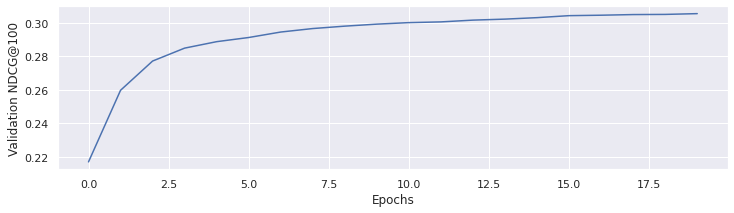

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

### Perdict and Evaluate

In [ ]:
test_data_tr, test_data_te = load_tr_te_data(
    os.path.join(output_dir, 'test_tr.csv'),
    os.path.join(output_dir, 'test_te.csv'), user_id=user_id, item_id=item_id, n_items=n_items)

In [ ]:
N_test = test_data_tr.shape[0]
idxlist_test = range(N_test)

batch_size_test = 2000

In [ ]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0)
saver, logits_var, _, _, _ = vae.build_graph()    

INFO:tensorflow:Scale of 0 disables regularizer.


In [ ]:
# Load the best performing model on the validation set:
chkpt_dir = PROJ_DIR + 'chkpt/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ./drive/My Drive/Colab Notebooks/RecSys/chkpt/VAE_anneal200.0K_cap3.2E-01/I-600-200-600-I


In [ ]:
# Predict and Eval:
n100_list, r20_list, r50_list = [], [], []

with tf.Session() as sess:
    saver.restore(sess, '{}/model'.format(chkpt_dir))

    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]
        shape = X.shape[0]

        # Add extra info:
        if data_type == "with_side_info":
            song_sm = sparse.csr_matrix(np.array(song_df.transpose()))
            X = scipy.sparse.vstack([X,song_sm])

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val[:shape], test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val[:shape], test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val[:shape], test_data_te[idxlist_test[st_idx:end_idx]], k=50))
    
n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

INFO:tensorflow:Restoring parameters from ./drive/My Drive/Colab Notebooks/RecSys/chkpt/VAE_anneal200.0K_cap3.2E-01/I-600-200-600-I/model


In [ ]:
# Results for best model:
print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=0.31700 (0.00099)
Test Recall@20=0.26628 (0.00104)
Test Recall@50=0.36554 (0.00114)
